### Image Mosaic
#### This notebook can be used to create mosaics that resembles a real image by replacing tiles of the image with small images that best resembles the original tile in terms of color histogram. Different functions can be used to fetch tiles that matches the original the best. This could be by grayscale, saturation or a third option. <br><br> Be aware that you have all necessary packages installed - they are loaded in the next cell. Any collection of images can be used, but this notebook uses the cifar10 image collection, with 50000 images of pixel size 32x32. It can be downloaded from: http://www.cs.toronto.edu/~kriz/cifar.html , and should be unpacked to a "data" folder located the same place as this notebook

In [1]:
#import necessary packages
from skimage import data, io, draw, color, transform
from skimage.io import imshow
import skimage
import numpy as np
import pandas as pd
import pickle
import skimage
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Function to load the cifar image collection
def load_cifar10(filename):
    """
    Loads a single batch of CIFAR images (10,000) from the given `filename`.

    In the CIFAR distribution, the color channels are placed as blocks
    within each image, meaning that all red pixels come before the green pixels
    which again are placed before the blue pixels. 
    
    The images returned from this function are converted to the channel-interleaved representation, 
    where the red, green, and blue channels for a single pixel are next to each other.
    """
    side_len = 32 # Square images of side length `side_len` 
    n_pixels_per_image = side_len * side_len
    with open(filename, 'rb') as f:
        cifar = pickle.load(f, encoding='bytes')
        # Change binary keys to string keys
        cifar = {str(key, encoding='ascii'): val for key, val in cifar.items()}

        images_rgb_in_blocks = skimage.img_as_float(cifar['data'])
        
        n_images = images_rgb_in_blocks.shape[0]
        n_channels = 3
        n_pixels_per_image = side_len * side_len
        
        images_rgb = np.zeros(n_images * n_pixels_per_image * n_channels)
        
        for channel_i in range(n_channels):
            channel = images_rgb_in_blocks.T[channel_i*n_pixels_per_image:(channel_i+1)*n_pixels_per_image]
            images_rgb[channel_i::n_channels] = channel.T.ravel()
            
        cifar['data'] = images_rgb.reshape(n_images, side_len, side_len, n_channels)
        
        return cifar['data'], cifar['labels']

In [3]:
#set tile size
tile_size = 32

#this is where the original image is loaded
integerrep = io.imread('data/leif.png')
#Convert the integer rep to float rep
floatrep = skimage.img_as_float(integerrep)

#load the collection of images 
images = []
for batch in range(1,6):
    #the cifar collection also contain labels, we do not consider this here,
    #but it could be used to only use pictures of kittens
    pictures, classes = load_cifar10('data/cifar-10-batches-py/data_batch_%s' % batch)
    images.extend(pictures)
images = np.array(images)
    
print("Image collection shape:", images.shape, ", Original image shape:", floatrep.shape)

Image collection shape: (50000, 32, 32, 3) , Original image shape: (700, 456, 3)


#### We'll now rescale the image to allow more tiles to replace the original tiles of the image. We'll cut away any excess rows/columns to make the image compatible to be replaced by the tile size: 32

120% Shape: (840, 547, 3)
bg_image Shape: (832, 544, 3)


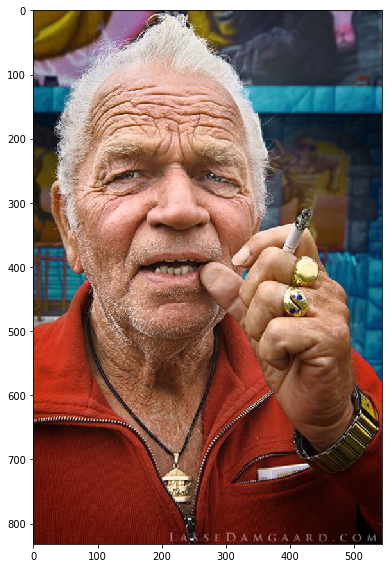

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) #ensures that pictures are displayed in bigger size

#Rescale the image to 120%
height = floatrep.shape[0] * 1.2
width = floatrep.shape[1] * 1.2
new_dimensions = (int(height), int(width))
hundred20 = transform.resize(floatrep, new_dimensions)

print("120% Shape: " + str(hundred20.shape))

#Adjust the shape of bg_image to reflect tile size
bgimageheight = int(height / tile_size) * tile_size
bgimagewidth = int(width / tile_size) * tile_size

#cutting away excess rows and columns
bg_image = hundred20[0:bgimageheight, 0:bgimagewidth]

print("bg_image Shape: " + str(bg_image.shape))

#display the "new" image
imshow(bg_image)

#### We'll need a function that can return tile coordinates of the image in order to replace the original color arrays with the best match. To demonstrate how it works, we'll run through the scaled image "bg_image" and replace the original tile with the mean array of the different color channels; r,g,b. This results in a low resolution image of the original

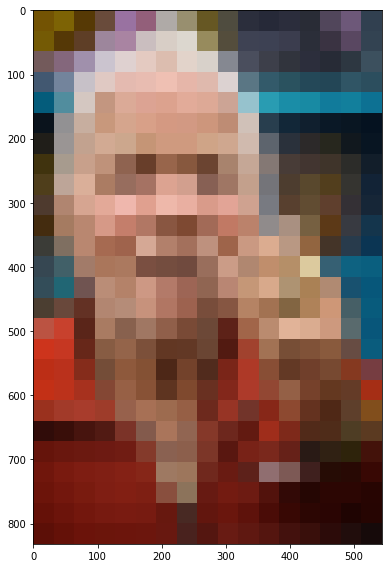

In [5]:
def tile_coordinates(i, j, tile_size):
    rowtile = int(i / tile_size)
    coltile = int(j / tile_size)
    if rowtile == 0:
        first = np.array((0, tile_size))
    elif rowtile != 0:
        ii = rowtile * tile_size
        first = np.array((ii, ii+tile_size))
    if coltile == 0:
        second = np.array((0, tile_size))
    elif coltile != 0:
        jj = coltile * tile_size
        second = np.array((jj, jj+tile_size))   
    return first, second

#to demonstrate
low_res = np.zeros(bg_image.shape)
for coord, _ in np.ndenumerate(low_res):
    if coord[0] % tile_size == 0 and coord[1] % tile_size:
        ii, jj = tile_coordinates(coord[0], coord[1], tile_size)
        r = np.mean(bg_image[ii[0]:ii[1], jj[0]:jj[1], 0])
        low_res[ii[0]:ii[1],jj[0]:jj[1],0] = r
        g = np.mean(bg_image[ii[0]:ii[1], jj[0]:jj[1], 1])
        low_res[ii[0]:ii[1],jj[0]:jj[1],1] = g
        b = np.mean(bg_image[ii[0]:ii[1], jj[0]:jj[1], 2])
        low_res[ii[0]:ii[1],jj[0]:jj[1],2] = b
        
imshow(low_res);

#### Perfect. Our tile coordinate function looks to be working as we want. In order to make a best match, we'll need some definition of how we calculate the "distance" between the tile from the original image and the "tile" from the collection of images. Here we'll use RGB histogram with 20 fixed bins to have high granularity. In addition to the rgbhist function, I also provide a couple of other functions to show how these can be constructed.

In [6]:
def rgbhist(image_rgb):
    bins = [round(a*0.05, 3) for a in range(0,21)]
    r = np.histogram(image_rgb[:,:,0], bins=bins)[0]
    g = np.histogram(image_rgb[:,:,1], bins=bins)[0]
    b = np.histogram(image_rgb[:,:,2], bins=bins)[0]
    rgb = np.array((r, g, b))
    return np.reshape(rgb, 60)

def average_color(image_rgb):
    red = np.mean(image_rgb[:,:, 0])
    green = np.mean(image_rgb[:,:, 1])
    blue = np.mean(image_rgb[:,:, 2])   
    # Return the average color across the image
    return np.array((red, green, blue))

def eightbyeightgrayscale(image_rgb): 
    #based on grayscale
    grayscale = color.rgb2gray(image_rgb)
    transformed = transform.resize(grayscale, (8, 8))
    transformed = np.reshape(transformed, 64)
    return transformed

def huesaturationhistogram(image_rgb):
    bins=[round(a*0.05, 3) for a in range(0,21)]
    hsvrep = color.rgb2hsv(image_rgb)
    hue = np.reshape(hsvrep[:,:, 0], 1024)
    sat = np.reshape(hsvrep[:,:, 1], 1024)
    huesathist, x, y = np.histogram2d(hue, sat, bins=bins)
    d1 = np.reshape(huesathist, 100)
    return d1

#### We'll also need a function that can efficiently calculate the distances between each combination of tile from the original image and the collection of images. For this purpose we load an additional distance function, cdist. The image_distance_query function takes in the tiles of the image as an array, the collection of images as an array, and finally the function which should be used to match the tile, to_vector_fn. 

In [7]:
from scipy.spatial.distance import cdist

def image_distance_query(query_images, collection_images, to_vector_fn, p=2):
    query_vecs = [to_vector_fn(image).reshape(1, -1) for image in query_images]
    query_vecs = np.concatenate(query_vecs)

    collection_vecs = [to_vector_fn(image).reshape(1, -1) for image in collection_images]
    collection_vecs = np.concatenate(collection_vecs)

    return cdist(query_vecs, collection_vecs, 'minkowski', p=p)

#### Now we're ready to create the mosaic. <li> First we'll create a placeholder that matches the size of the bg_image</li> <li> Then we create a placeholder for the tiles of the mosaic </li> <li> We then iterate over the mosaic to extract the tiles from the original image with our tile_coordinate function </li>

In [8]:
mosaic = np.zeros(bg_image.shape)

#array to hold all query images from bg_image
query_images = np.empty((int(mosaic.shape[0]/tile_size) * int(mosaic.shape[1]/tile_size), tile_size, tile_size, 3))

q = 0
#extracting tiles from bg_image
for i, el in enumerate(mosaic):
    for j, _ in enumerate(el):
        if i % tile_size == 0 and j % tile_size == 0:
            ii, jj = tile_coordinates(i, j, tile_size)
            tile_r = bg_image[ii[0]:ii[1], jj[0]:jj[1], 0]
            query_images[q, :, :, 0] = tile_r
            tile_g = bg_image[ii[0]:ii[1], jj[0]:jj[1], 1]
            query_images[q, :, :, 1] = tile_g
            tile_b = bg_image[ii[0]:ii[1], jj[0]:jj[1], 2]
            query_images[q, :, :, 2] = tile_b
            q += 1
            
print('Shape of query images; (No. tiles, width, height, depth)', query_images.shape)

Shape of query images; (No. tiles, width, height, depth) (442, 32, 32, 3)


#### Now we use the image_distance_query to calculate the distance between our tile/image combinations. Then we iterate over the mosaic to assign the image from the collection to which there was the smallest distance. And finally we can display the mosaic. 

In [9]:
distances = image_distance_query(query_images, images, rgbhist)

q = 0
for i, el in enumerate(mosaic):
    for j, _ in enumerate(el):
        if i % tile_size == 0 and j % tile_size == 0:
            ii, jj = tile_coordinates(i, j, tile_size)
            match = distances[q].argsort().ravel()[0]
            mosaic[ii[0]:ii[1],jj[0]:jj[1]] = images[match]
            q += 1

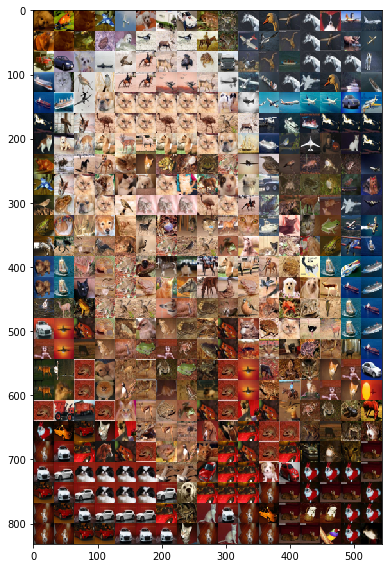

In [10]:
imshow(mosaic)